### 1) Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import time
import seaborn as sns

from sklearn.feature_selection import RFECV
from sklearn import model_selection 
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from sklearn import tree

import xgboost as xgb

C:\Users\Milan\Anaconda3\lib\site-packages\dask\dataframe\utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Exploratory Data Analysis

In [2]:
def exploratory_data_analysis_report(df):
    print(' ------ describe dataset ------ ')
    print(df.describe())
    print(' ------ number of NaN values: ------ ')
    print(df.isna().sum())
    print(' ------ unique values per column ------ ')
    print(df.nunique())
    # EDA plots    
    numeric_column_names = df._get_numeric_data().columns
    df_num = df[numeric_column_names]
    sns.pairplot(df_num)
    
    df.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);
    
    sns.boxplot(x=df['amount_tsh'])
    sns.boxplot(x=df[df['amount_tsh']<5000]['amount_tsh'])

### Preprocessing

In [7]:
def reduce_number_of_classes_per_feature(df):
    # change columns with too many variables. We took 15 as our minimum amount of occurences of a class
    # which is comparable with roughly 1 in 4000 cases should be represented by a class
    print('Reducing maximum number of classes per feature...')
    df_numeric_column_names = list(df._get_numeric_data().columns)
    df_numeric_column_names.append('date_recorded')
    column_names_not_numeric_features = [x for x in df.columns if x
            not in df_numeric_column_names]
    for column_name in column_names_not_numeric_features:
        value_counts = df[column_name].value_counts()
        lessthen = value_counts[value_counts < 15]
        mask = df.installer.isin(list(lessthen.keys()))
        df.loc[mask, column_name] = 'other'
    return df


def impute_numerical_features(df):
    print('Imputing numerical features...')
    # GPS data
    feature_names = ['longitude', 'latitude', 'gps_height']
    for feature in feature_names:
        if feature == 'latitude':
            a = df[df[feature] == -2e-08]
            a.iloc[:, df.columns == feature] = np.nan
            df[df[feature] == -2e-08] = a
            df[feature] = df.groupby('region_code').transform(lambda x: \
                    x.fillna(x.mean()))[feature]
        else:
            a = df[df[feature] < 0]
            a.iloc[:, df.columns == feature] = np.nan
            df[df[feature] < 0] = a
            df[feature] = df.groupby('region_code').transform(lambda x: \
                    x.fillna(x.mean()))[feature]
    # construction year
    average_construction_year = round(df[df.construction_year
            > 0].construction_year.mean())
    df.loc[df.construction_year <= 0, df.columns == 'construction_year'
           ] = average_construction_year

    return df


def outlier_detection_and_imputation(df):
    print('Outlier detection...')
    indexes_to_impute = df[np.abs(df['amount_tsh'] - df['amount_tsh'
                           ].mean()) >= 3 * df['amount_tsh'
                           ].std()].index
    df['amount_tsh'].iloc[indexes_to_impute] = np.nan
    df['amount_tsh'] = df['amount_tsh'].fillna(df['amount_tsh'].mean())
    return df


def impute_booleans(df):
    print('Imputing Booleans...')
    columns = ['permit', 'public_meeting']
    for column in columns:
        mask = df[column] ==True
        df[column].loc[mask] = 'True_string'
        mask = df[column]==False 
        df[column].loc[mask] = 'False_string'
    return df


def preprocessing(df):
    print(' ------ Preprocessing ------ ')
    df = df.drop(['quantity', 'recorded_by','waterpoint_type', 'payment'],axis=1)
    df = outlier_detection_and_imputation(df)
    df = impute_numerical_features(df)
    df = df.fillna('unknown')
    df = reduce_number_of_classes_per_feature(df)
    df = impute_booleans(df)
    return df




### Feature Generation:

In [8]:
def elbow_curve(df):
    print('Plotting Elbow curve...')
    K_clusters = range(1, 10)
    kmeans = [KMeans(n_clusters=i) for i in K_clusters]
    Y_axis = df[['latitude']]
    X_axis = df[['longitude']]
    score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in
             range(len(kmeans))]

    # Visualize
    plt.plot(K_clusters, score)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Score')
    plt.title('Elbow curve: Error given number of clusters selected')
    plt.show()
    print('3 clusters selected')
    return 3


def create_geo_cluster_feature(df):
    print('Create geo cluster feature...')
    n = elbow_curve(df)
    kmeans = KMeans(n_clusters=n, init='k-means++')
    a = df[['id', 'latitude', 'longitude']]
    kmeans.fit(a[a.columns[1:3]])  # Compute k-means clustering.
    a['cluster_label'] = kmeans.fit_predict(a[a.columns[1:3]])
    df['geo_cluster'] = a['cluster_label']
    return df


def create_datetime_features(df):
    import datetime
    print('Create datetime features...')
    date_recorder = list(map(lambda x: \
                         datetime.datetime.strptime(str(x), '%Y-%m-%d'
                         ), df['date_recorded'].values))
    df['year_recorded'] = list(map(lambda x: int(x.strftime('%Y')),
                               date_recorder))
    df['day_of_week_recorded'] = list(map(lambda x: int(x.strftime('%w')),
                                      date_recorder))
    df['week_of_year_recorded'] = list(map(lambda x: int(x.strftime('%W')),
                                       date_recorder))
    df['month_recorded'] = list(map(lambda x: int(x.strftime('%m')),
                                date_recorder))
    df['age'] = df['year_recorded'].values - df['construction_year'
            ].values
    del df['date_recorded']
    return df


def feature_generation(df):
    print(' ------ Feature Generation ------ ')
    df = create_datetime_features(df)
    df = create_geo_cluster_feature(df)
    return df

#### Feature Selection & Label Encoding

In [9]:
def show_feature_importances(df, X_train, y_train):
    print('Plot xgboost feature importances...')
    # fit model no training data
    model = xgb.XGBClassifier()
    model.fit(X_train, y_train)
    importances = model.feature_importances_
    indices = np.argsort(importances)

    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b',
             align='center')
    plt.yticks(range(len(indices)), [df.columns[i] for i in
               indices])
    plt.xlabel('Relative Importance')
    plt.show()
  

def xgboost_RFECV(X_train,y_train):
    print('Feature Selection using RFECV...')
    temp_model = xgb.XGBClassifier(learning_rate=0.1, n_estimators=50,
                                   max_depth=5)
    rfecv = RFECV(estimator=temp_model, step=1,
                  cv=model_selection.StratifiedKFold(2),
                  scoring='accuracy')
    rfecv.fit(X_train, y_train)
    print('     -RFECV report')
    print('     -Optimal number of features : {}'.format(rfecv.n_features_))
    print('     -Selector ranking: {}'.format(rfecv.ranking_))
    
    
    # Plot number of features VS. cross-validation scores
    plt.figure()
    plt.title('XGB CV score vs No of Features')
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (nb of correct classifications)")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.show()
    
    support = rfecv.support_
    return support


def feature_selection(df, target):
    print(' ------ Feature Selection ------ ')
    (X_train, X_test, y_train, y_test) = \
        train_test_split(df.values, target, test_size=0.2)
    show_feature_importances(df, X_train, y_train)
    support = xgboost_RFECV(X_train, y_train)
    selected_features = df.loc[:, support]
    return selected_features
   
    
def label_encoding(df,df_labels):
    from sklearn import preprocessing
    le = preprocessing.LabelEncoder()
    df_objects = df.loc[:, df.dtypes == 'object']
    for column in df_objects:
        df[column] = preprocessing.LabelEncoder().fit_transform(df[column])
    target = preprocessing.LabelEncoder().fit_transform(df_labels.status_group)    
    return df, target



### Parameter Tuning:

In [10]:
def create_train_test_set(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    return X_train, X_test, y_train, y_test


def GridSearchCV_1(X_train, y_train):
    print ('GridSearch1, tuning max depth and min_child_weight...')
    t0 = time.time()
    param_test1 = {'max_depth': range(3, 10, 2),
                   'min_child_weight': range(1, 6, 2)}
    gsearch1 = model_selection.GridSearchCV(  # n_estimators=140,
                              # objective= 'binary:logistic'
        estimator= xgb.XGBClassifier(
            learning_rate=0.1,
            n_estimators=50,
            max_depth=5,
            min_child_weight=1,
            gamma=0,
            subsample=0.8,
            colsample_bytree=0.8,
            nthread=4,
            scale_pos_weight=1,
            seed=27,
            ),
        param_grid=param_test1,
        scoring='accuracy',
        n_jobs=4,
        iid=False,
        cv=5,
        verbose=10
        )

    from sklearn import preprocessing
    gsearch1.fit(X_train, y_train)
    t1 = time.time()
    total_time = t1 - t0
    print ('Grid Search time: {}'.format(t1 - t0))
    print ('Grid best score: {}'.format(gsearch1.best_score_))
    print ('Best parameters scores: {}'.format(gsearch1.best_params_))
    best_max_depth = gsearch1.best_params_['max_depth']
    best_min_child_weight = gsearch1.best_params_['min_child_weight']
    return (best_max_depth, best_min_child_weight)


def GridSearchCV_2(
    X_train,
    y_train,
    best_max_depth,
    best_min_child_weight,
    ):

    # Tune gamma

    print ('GridSearch2, tuning gamma...')
    import time

    t0 = time.time()
    param_test2 = {'gamma': [i / 10.0 for i in range(0, 5)]}
    gsearch2 = model_selection.GridSearchCV(  # n_estimators=140,
                              # added this myself, for extra information
        estimator= xgb.XGBClassifier(
            learning_rate=0.1,
            n_estimators=50,
            max_depth=best_max_depth,
            min_child_weight=best_min_child_weight,
            gamma=0,
            subsample=0.8,
            colsample_bytree=0.8,
            objective='binary:logistic',
            nthread=4,
            scale_pos_weight=1,
            seed=27,
            ),
        param_grid=param_test2,
        scoring='accuracy',
        n_jobs=4,
        iid=False,
        cv=5,
        verbose=10,
        )
    gsearch2.fit(X_train, y_train)

    t1 = time.time()
    total_time2 = t1 - t0
    print ('Grid Search time: {}'.format(t1 - t0))
    print ('Grid best score: {}'.format(gsearch2.best_score_))
    print ('Best parameters scores: {}'.format(gsearch2.best_params_))
    best_gamma = gsearch2.best_params_['gamma']
    return best_gamma


def GridSearchCV_3(
    X_train,
    y_train,
    best_max_depth,
    best_min_child_weight,
    best_gamma,
    ):

    # Tune subsample and colsample_bytree

    t0 = time.time()
    print ('GridSearch3, tuning subsample and colsample_bytree...')

    param_test3 = {'subsample': [i / 10.0 for i in range(6, 10)],
                   'colsample_bytree': [i / 10.0 for i in range(6, 10)]}
    gsearch3 = model_selection.GridSearchCV(  # n_estimators=177,
        estimator= xgb.XGBClassifier(
            learning_rate=0.1,
            n_estimators=50,
            max_depth=best_max_depth,
            min_child_weight=best_min_child_weight,
            gamma=best_gamma,
            subsample=0.8,
            colsample_bytree=0.8,
            objective='binary:logistic',
            nthread=4,
            scale_pos_weight=1,
            seed=27,
            ),
        param_grid=param_test3,
        scoring='accuracy',
        n_jobs=4,
        iid=False,
        cv=5,
        verbose=10
        )

    gsearch3.fit(X_train, y_train)
    t1 = time.time()
    total_time3 = t1 - t0
    print ('Grid Search time: {}'.format(t1 - t0))
    print ('Grid best score: {}'.format(gsearch3.best_score_))
    print ('Best parameters scores: {}'.format(gsearch3.best_params_))
    best_subsample = gsearch3.best_params_['subsample']
    best_colsample_bytree = gsearch3.best_params_['colsample_bytree']
    return (best_subsample, best_colsample_bytree)

def parameter_tuning(X_train,y_train):
    print(' ------ Parameter tuning ------ ')
    best_max_depth, best_min_child_weight = GridSearchCV_1(X_train,
                                                           y_train
                                                          )
    best_gamma = GridSearchCV_2(X_train, y_train, 
                                best_max_depth, 
                                best_min_child_weight
                               )
    best_subsample, best_colsample_bytree = GridSearchCV_3(X_train, y_train, 
                                                           best_max_depth, 
                                                           best_min_child_weight, 
                                                           best_gamma
                                                          )
    tuned_parameters = [best_max_depth, best_min_child_weight, best_gamma, best_subsample, best_colsample_bytree]
    return tuned_parameters

### Modelling (build, train and predict):

In [20]:
def build_model(tuned_parameters, X_test, y_test):
    print(' ------ Build model ------ ')
    learning_rate = 0.01
    n_estimators = 5000
    model = xgb.XGBClassifier(
     learning_rate =learning_rate,
     n_estimators=n_estimators,
     max_depth=tuned_parameters[0],
     min_child_weight=tuned_parameters[1],
     gamma=tuned_parameters[2],
     subsample=tuned_parameters[3],
     colsample_bytree=tuned_parameters[4],
     reg_alpha= 0.005,
     objective= 'accuracy',
     nthread=4,
     scale_pos_weight=1,
     seed=27,
     eval_metric="error",
     verbose=10
    )
    return model

def train_model(model, X_train, y_train):
    print(' ------ Train Model ------ ')
    model.fit(X_train,y_train) 
    return model

def prediction(model, X_test, y_test):
    print(' ------ Make Prediction ------ ')
    y_pred = model.predict(X_test) 
    return model, y_pred


### Evaluation

In [12]:
def create_confusion_matrix(model, X_test, y_test):
    print('Creating Confusion matrix')
    from sklearn.metrics import plot_confusion_matrix
    class_names = df_labels.status_group.unique()
    # Plot non-normalized confusion matrix
    titles_options = [("Confusion matrix, without normalization", None),
                      ("Normalized confusion matrix", 'true')]
    for title, normalize in titles_options:
        disp = plot_confusion_matrix(model, 
                                     X_test, y_test,
                                     display_labels=class_names,
                                     cmap=plt.cm.PuRd,
                                     normalize=normalize)
        disp.ax_.set_title(title)
        plt.grid(False)
        plt.show()
        
def prediction_accuracy(model, X_test, y_test, y_pred):
    prediction = model.predict(X_test)
    print('Accuracy of the model is: {}'.format(metrics.accuracy_score(y_test, y_pred)))
    
def evaluation(xgb_model, X_test, y_test, y_pred):
    create_confusion_matrix(xgb_model, X_test, y_test)
    prediction_accuracy(xgb_model, X_test, y_test, y_pred)

### Submission

In [13]:
def create_submission_csv(X_test,y_pred):
    print(' ------ Create Submission ------ ')
    test_data_indexes = pd.DataFrame(data=X_test).index
    submission_df = pd.DataFrame({'id':test_data_indexes , 'status_group':y_pred})
    #Not enough rows for current submission (11... instead of 14850)
    submission_df.to_csv('SubmissionFormat.csv', index=False)

 ------ describe dataset ------ 
                 id     amount_tsh    gps_height     longitude      latitude  \
count  59400.000000   59400.000000  59400.000000  59400.000000  5.940000e+04   
mean   37115.131768     317.650385    668.297239     34.077427 -5.706033e+00   
std    21453.128371    2997.574558    693.116350      6.567432  2.946019e+00   
min        0.000000       0.000000    -90.000000      0.000000 -1.164944e+01   
25%    18519.750000       0.000000      0.000000     33.090347 -8.540621e+00   
50%    37061.500000       0.000000    369.000000     34.908743 -5.021597e+00   
75%    55656.500000      20.000000   1319.250000     37.178387 -3.326156e+00   
max    74247.000000  350000.000000   2770.000000     40.345193 -2.000000e-08   

        num_private   region_code  district_code    population  \
count  59400.000000  59400.000000   59400.000000  59400.000000   
mean       0.474141     15.297003       5.629747    179.909983   
std       12.236230     17.587406       9.633649

C:\Users\Milan\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Milan\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Reducing maximum number of classes per feature...
Imputing Booleans...
 ------ Feature Generation ------ 
Create datetime features...
Create geo cluster feature...
Plotting Elbow curve...


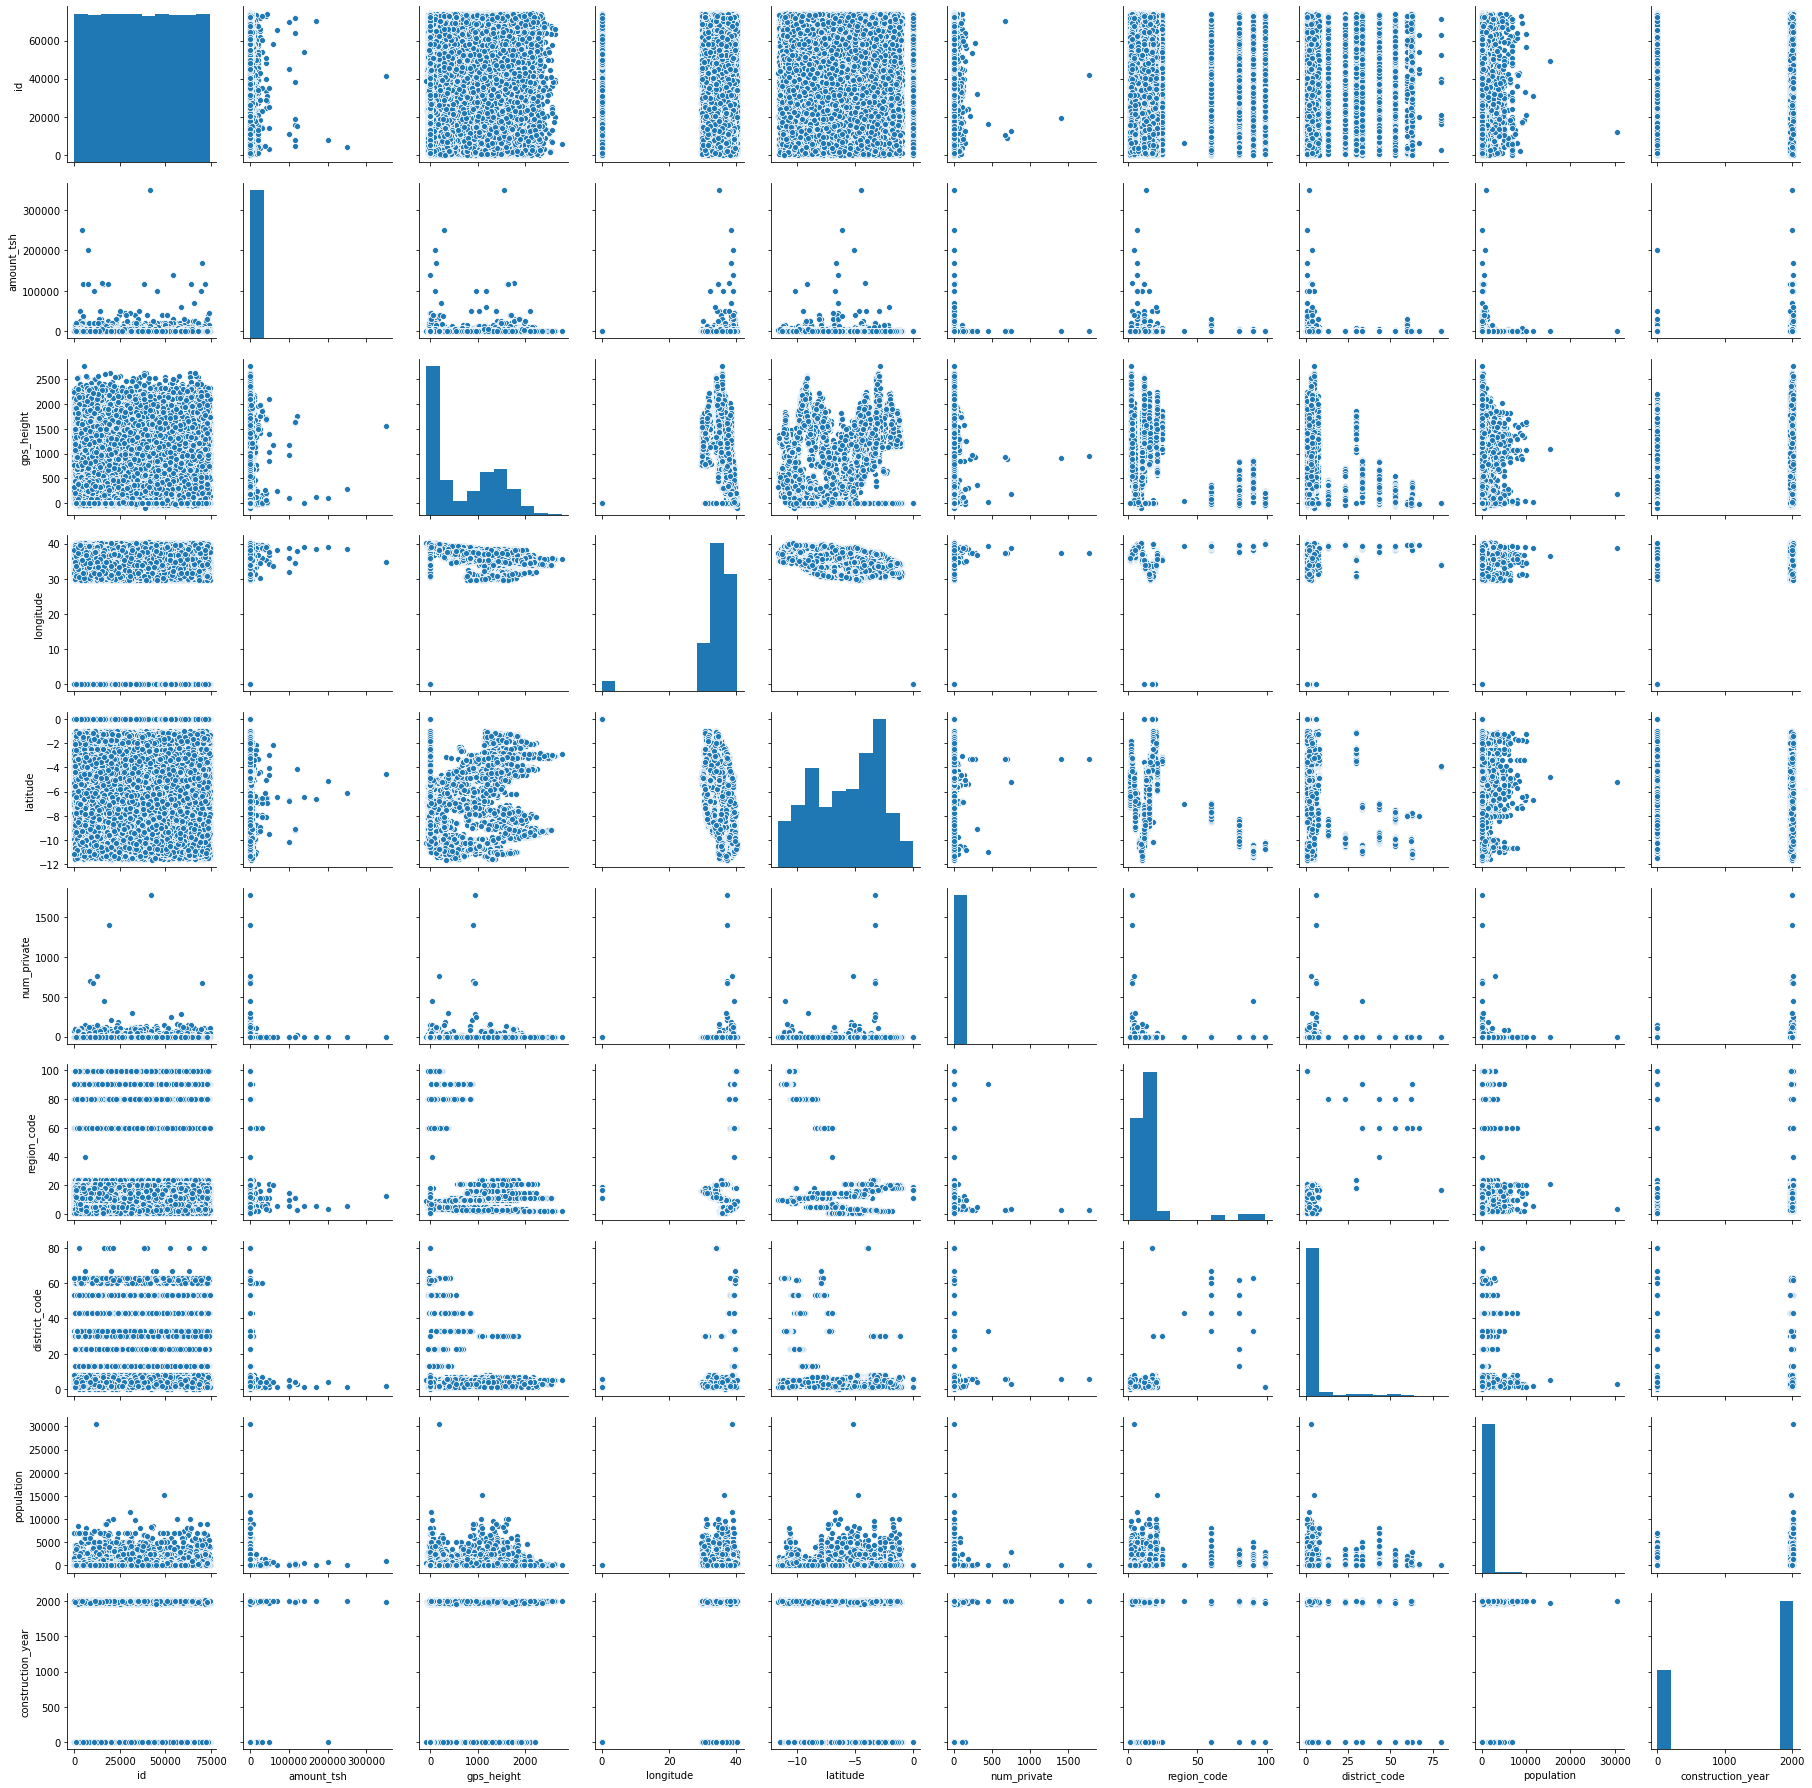

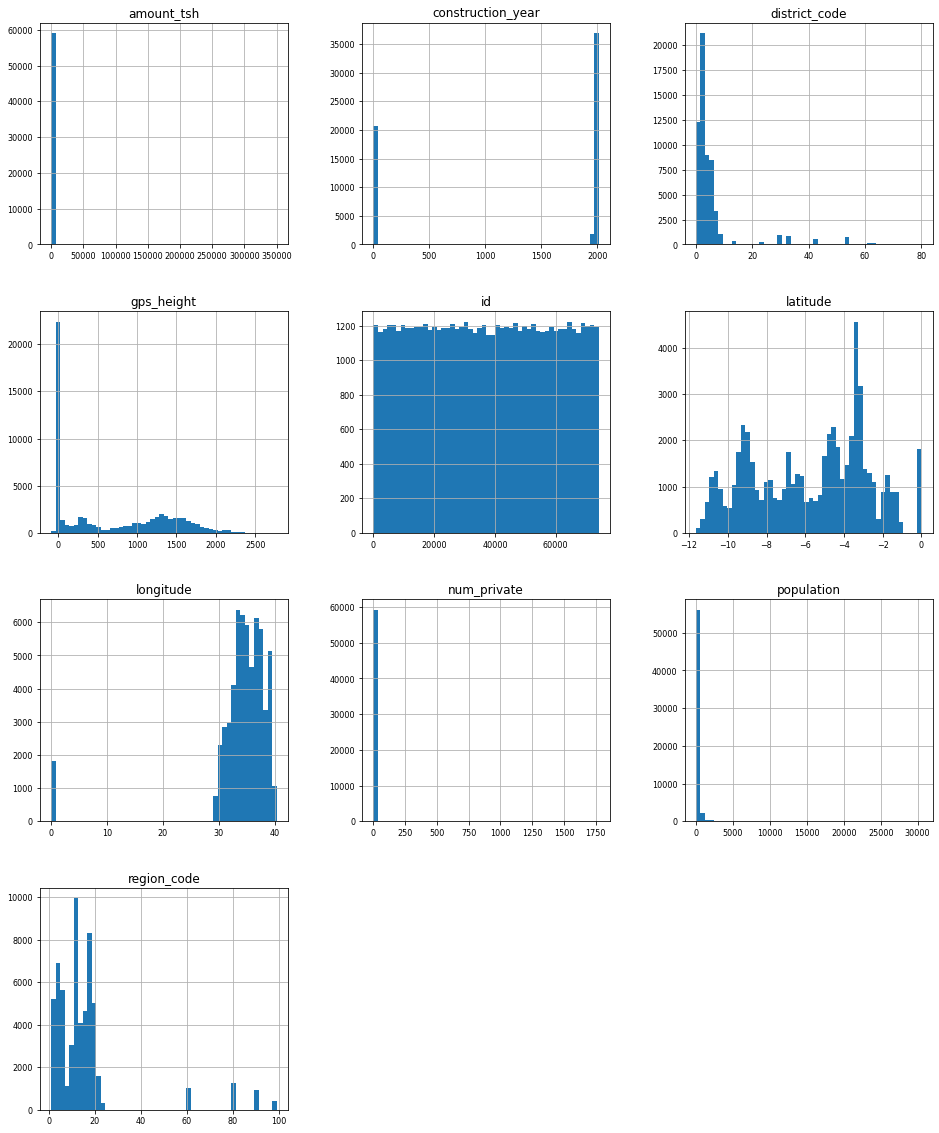

3 clusters selected


C:\Users\Milan\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


 ------ Feature Selection ------ 
Plot xgboost feature importances...


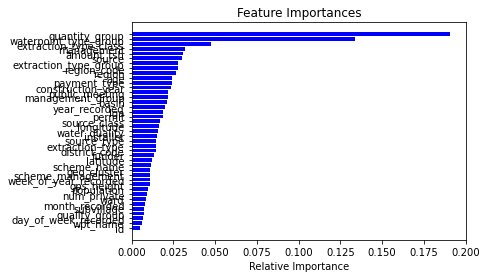

Feature Selection using RFECV...
     -RFECV report
     -Optimal number of features : 31
     -Selector ranking: [10  1  1  1  1  1  1  9  5  1  6  1  1  1  1  7  1  1  3  1  1  1  1  1
  1  1  1  1  1  2  1  1  1  1  1  1  8  4 11  1  1]


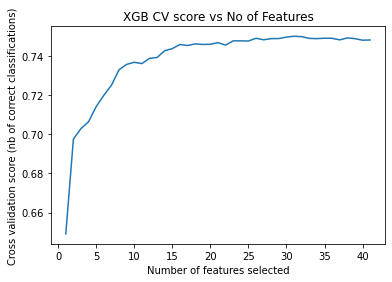

In [22]:
#Setup
df = pd.read_csv('data.csv')
df_labels = pd.read_csv('labels.csv')
#pipeline 1
exploratory_data_analysis_report(df)
df = preprocessing(df)
df = feature_generation(df)
df, target = label_encoding(df, df_labels)
selected_features = feature_selection(df, target)

In [18]:
#pipeline2
X_train, X_test, y_train, y_test = create_train_test_set(selected_features, target)
tuned_parameters = parameter_tuning(X_train,y_train)

 ------ Parameter tuning ------ 
GridSearch1, tuning max depth and min_child_weight...
Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   15.1s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   20.8s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:   34.2s
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:   48.9s
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  2.5min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  3.0min remaining:    0.0s
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  3.0min finished
C:\Users\Milan\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


[14:06:38] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Grid Search time: 187.82649874687195
Grid best score: 0.7917508417508416
Best parameters scores: {'max_depth': 9, 'min_child_weight': 1}
GridSearch2, tuning gamma...
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   30.8s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   47.7s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done  21 out of  25 | elapsed:  1.6min remaining:   18.2s
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:  1.7min finished
C:\Users\Milan\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


[14:08:31] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Grid Search time: 113.01647734642029
Grid best score: 0.7923821548821548
Best parameters scores: {'gamma': 0.1}
GridSearch3, tuning subsample and colsample_bytree...
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   26.5s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   41.6s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  1.5min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  4.5min
[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed:  5.8min finished
C:\Users\Milan\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


[14:14:30] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Grid Search time: 358.5344924926758
Grid best score: 0.7930976430976431
Best parameters scores: {'colsample_bytree': 0.6, 'subsample': 0.8}


 ------ Build model ------ 
 ------ Train Model ------ 
[14:18:53] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { scale_pos_weight, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


 ------ Make Prediction ------ 
Creating Confusion matrix


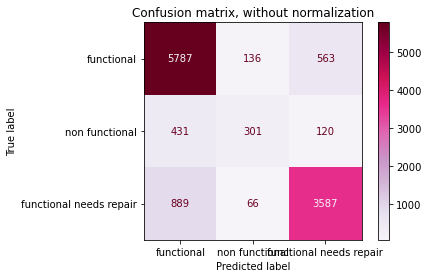

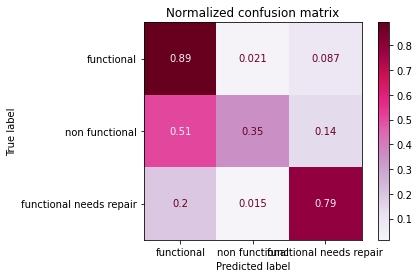

Accuracy of the model is: 0.8143939393939394


In [21]:
#pipeline3
xgb_model = build_model(tuned_parameters, X_test, y_test)
xgb_model = train_model(xgb_model, X_train, y_train)
xgb_model, y_pred = prediction(xgb_model, X_test, y_test)
evaluation(xgb_model, X_test, y_test, y_pred)